In [7]:
%reload_ext autoreload
%autoreload 2

In [5]:
!pip install -U fastai
!pip install -U fastbook

In [9]:
# Import necessary modules from the fastai library

import os
from fastai.vision.all import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
DATASET_PATH  = '/content/drive/MyDrive/ColabData/ptf_classifier'

class_names = []
for folder_name in os.listdir(DATASET_PATH):
  class_names.append(folder_name)

class_names

['yes-helmet', 'no-helmet', 'val', 'models', '.ipynb_checkpoints']

In [21]:
image_paths = []
labels = []

for i in range(len(class_names)):
    class_name = class_names[i]
    image_names = os.listdir(f'{DATASET_PATH}/{class_name}')
    for image_name in image_names:
        image_path = f'{DATASET_PATH}/{class_name}/{image_name}'
        image_paths.append(image_path)
        labels.append(i)

In [22]:
df = pd.DataFrame(
    {
        'name': image_paths,
        'label': labels
    }
)

In [23]:
df.head()

,name,label
0,/content/drive/MyDrive/ColabData/ptf_classifier/yes-helmet/img_1.jpg,0
1,/content/drive/MyDrive/ColabData/ptf_classifier/yes-helmet/img_2.jpg,0
2,/content/drive/MyDrive/ColabData/ptf_classifier/yes-helmet/img_3.jpeg,0
3,/content/drive/MyDrive/ColabData/ptf_classifier/yes-helmet/img_4.jpeg,0
4,/content/drive/MyDrive/ColabData/ptf_classifier/yes-helmet/img_5.jpg,0


In [24]:
df.tail()

,name,label
18,/content/drive/MyDrive/ColabData/ptf_classifier/no-helmet/test_4.jpg,1
19,/content/drive/MyDrive/ColabData/ptf_classifier/no-helmet/test_5.jpg,1
20,/content/drive/MyDrive/ColabData/ptf_classifier/no-helmet/test_6.jpg,1
21,/content/drive/MyDrive/ColabData/ptf_classifier/no-helmet/test_7.jpg,1
22,/content/drive/MyDrive/ColabData/ptf_classifier/models/stage__1.pth,3


In [25]:
df.to_csv(
    path_or_buf=f'{DATASET_PATH}/labels.csv',
    index=False
)

In [28]:
dls = ImageDataLoaders.from_folder(
    path=DATASET_PATH,
    item_tfms=Resize(224),
    bs=16,
    batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()],
    valid_pct=0.2
)

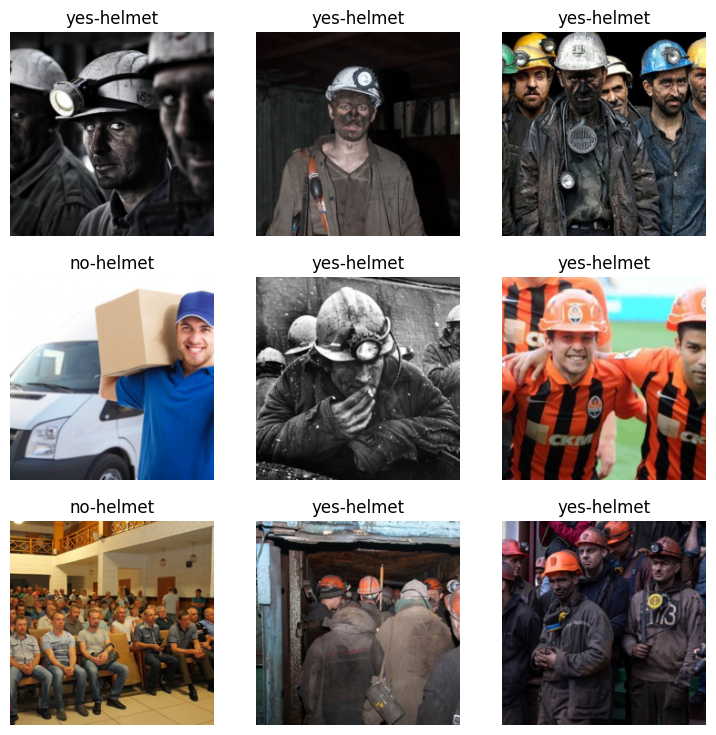

In [29]:
dls.show_batch()

In [30]:
model = vision_learner(
    dls=dls,
    arch=models.resnet50,
    metrics=[accuracy, error_rate]
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [31]:
model.fine_tune(
    epochs=1
)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.606530,2.667721,0.250000,0.750000,00:02


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.521504,2.119418,0.250000,0.750000,00:00


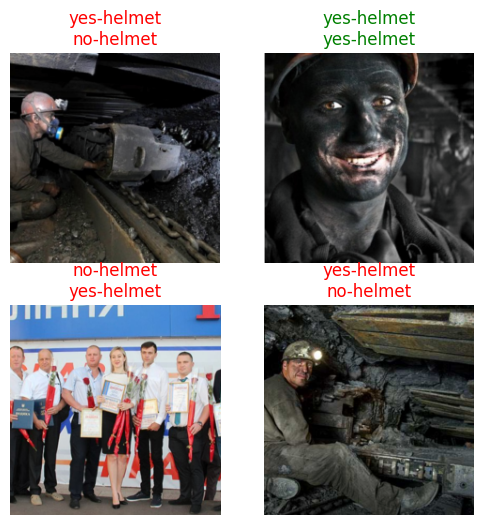

In [32]:
model.show_results()

In [33]:
model.export('/content/drive/MyDrive/ColabData/ptf_classifier/models/helm_classifier.pkl')

In [34]:
new_model = load_learner(f'{DATASET_PATH}/models/helm_classifier.pkl')

In [35]:
new_model.predict(
    item='/content/drive/MyDrive/ColabData/ptf_classifier/predict/predict_helm.jpg'
)

('yes-helmet', tensor(1), tensor([0.0599, 0.9401]))

In [36]:
new_model.predict(
    item='/content/drive/MyDrive/ColabData/ptf_classifier/predict/predict_helm_2.jpg'
)

('no-helmet', tensor(0), tensor([0.7712, 0.2288]))

In [37]:
data = ImageDataLoaders.from_folder(
    path=DATASET_PATH,
    item_tfms=Resize(224),
    bs=16,
    batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()],
    valid_pct=0.2
)


19 4


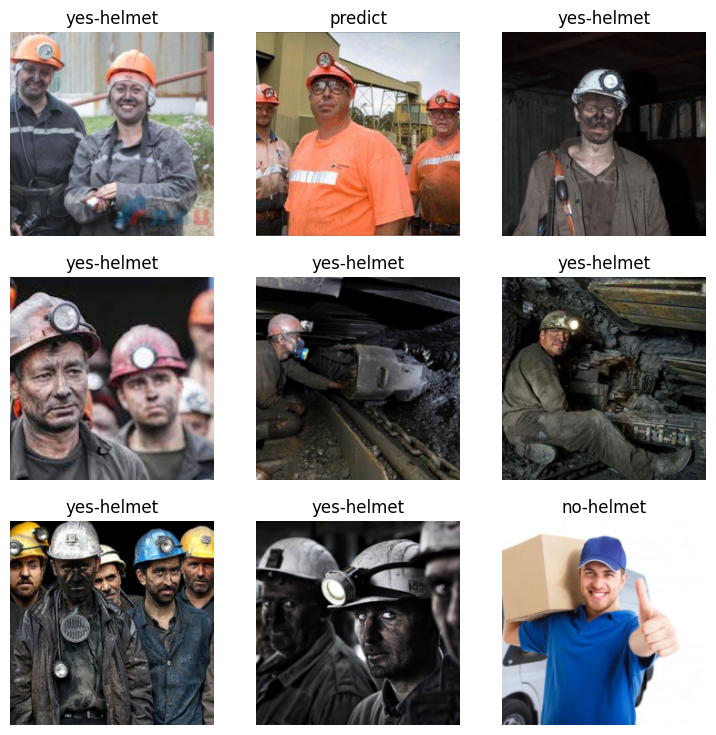

In [38]:
# Show what the data looks like after being transformed
data.show_batch()
# See the classes and count of classes in your dataset
# print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [39]:
# Building the CNN model with the pretrained resnet34
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s]


In [40]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.264663,6.310950,0.000000,00:00
1,2.238654,4.332827,0.250000,00:00
2,2.051876,3.225014,0.250000,00:00
3,1.913827,2.476761,0.250000,00:00


In [41]:
# Saving the model
learn.save('stage__1')

# Loading the Model
learn.load('stage__1')


SuggestedLRs(valley=0.00019054606673307717)

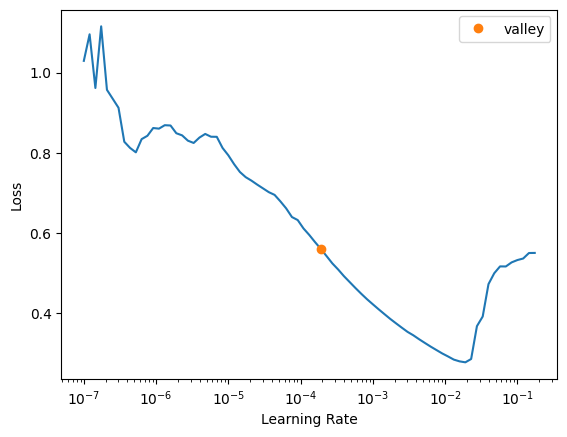

In [43]:
# Unfreeze all layers of the CNN
learn.unfreeze()
# Find the optimal learning rate and plot a visual
learn.lr_find()

In [61]:
# Fitting the model over 2 epochs. Increased the accuracy to 94%
learn.fit_one_cycle(3, max_lr=slice(3e-7, 3e-6))

In [46]:
# Building a Classification Interpretation object from our learn model
interp = ClassificationInterpretation.from_learner(learn)

In [62]:
# Showing top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

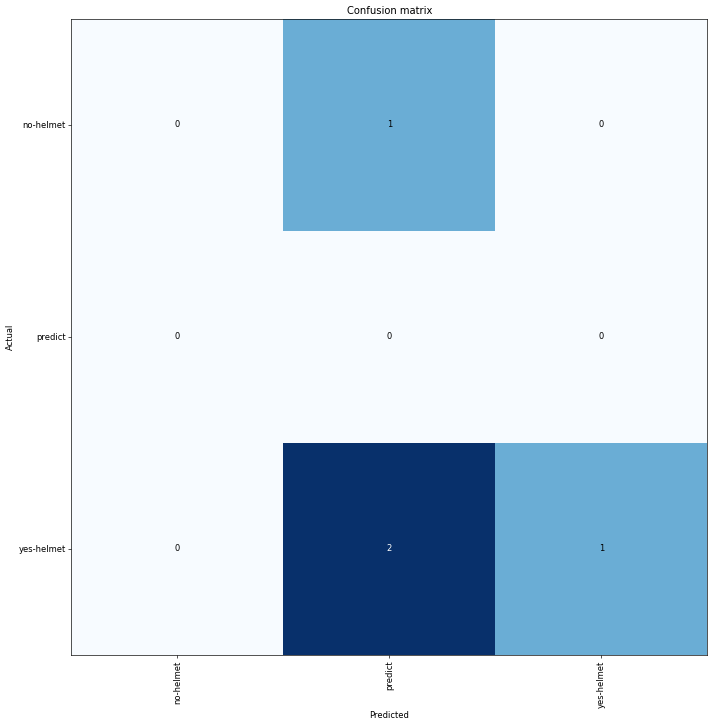

In [48]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [49]:
interp.most_confused(min_val=2)

[('yes-helmet', 'predict', 2)]

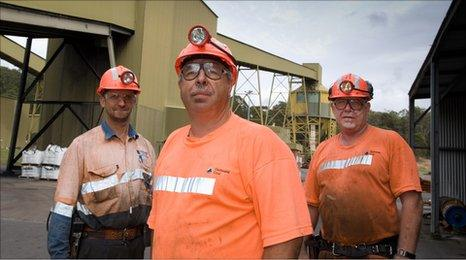

In [50]:
from PIL import Image
# Your file path
filename = '/content/drive/MyDrive/ColabData/ptf_classifier/predict/predict_helm.jpg'
# Open the image using PIL
img = Image.open(filename)
img

In [51]:
pred = learn.predict(img)
print(pred)

('predict', tensor(1), tensor([0.0271, 0.9547, 0.0182]))
